# Example: Score-Based Generative Model for 2D Swiss Roll Dataset

## Generate Swiss Roll Dataset

In [1]:
from sklearn.datasets import make_swiss_roll
import numpy as np

import torch
import torch.nn as nn
# from torch.nn import init
# from torch.nn import functional as F
# import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML
from IPython.display import clear_output

import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm.notebook import trange

# Set the device 
device = 'mps' # 'cuda' or 'cpu'

In [2]:
def generate_swiss_roll_dataset(n_samples=1000, noise=0.0, random_state=None):
    """
    Function to generate Swiss Roll dataset.

    Parameters:
    n_samples (int): The total number of points equally divided among classes.
    noise (float): Standard deviation of Gaussian noise added to the data.
    random_state (int): Determines random number generation for dataset creation. 

    Returns:
    X (torch.Tensor): The generated samples.
    t (torch.Tensor): The univariate position of the sample according to the main dimension of the points in the Swiss Roll.
    """
    X, t = make_swiss_roll(n_samples, noise=noise, random_state=random_state)
    X = X[:, [0, 2]]
    # Scale and normalize to [-1,1]
    X = (X - np.min(X)) / (np.max(X) - np.min(X))
    X = 10 * X - 5

    # Convert to PyTorch tensors
    X = torch.from_numpy(X).float()
    t = torch.from_numpy(t).float()

    return X, t

# Generate Swiss Roll dataset
X, t = generate_swiss_roll_dataset(n_samples=100000, noise=0.3, random_state=42)
print(f"Swiss Roll dataset: {X.shape}")
print(f"Labels: {t.shape}")


Swiss Roll dataset: torch.Size([100000, 2])
Labels: torch.Size([100000])


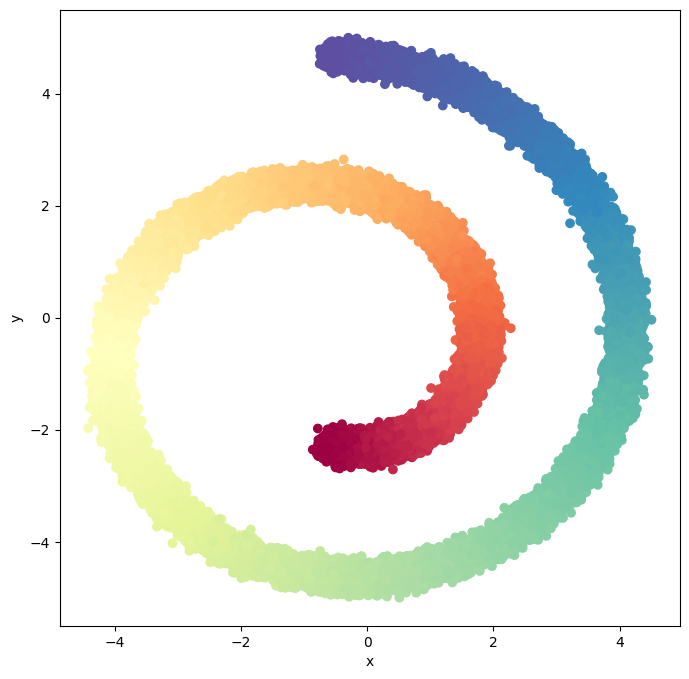

In [3]:
# function to Plot 2d Swiss Roll dataset
def plot_2d_swiss_roll(X, t=None, title="Swiss Roll data"):
    if t is None:
        t = np.zeros(X.shape[0])
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    ax.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.Spectral)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.show()

plot_2d_swiss_roll(X, t, title="Swiss Roll dataset")


# Implmeneting Score-Based Generative Model

## Score Function 

In [4]:
class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  # [\sin(2\pi \omega t) ; \cos(2\pi \omega t)]
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

### Define the Score Model 

In [5]:
class ScoreNet(nn.Module):

  def __init__(self, marginal_prob_std, input_dim=2, hidden_dim=512, output_dim=2, embed_dim=256):
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
      nn.Linear(embed_dim, embed_dim),
      nn.GELU()
    )
      
    self.linear_model1 = nn.Sequential(
      nn.Linear(input_dim, embed_dim),
      nn.Dropout(0.2),
      nn.GELU()
    )

    self.linear_model2 = nn.Sequential(
      nn.Linear(embed_dim, hidden_dim),
      nn.Dropout(0.2),
      nn.GELU(),
      
      nn.Linear(hidden_dim, hidden_dim),
      nn.Dropout(0.2),
      nn.GELU(),
      
      nn.Linear(hidden_dim, input_dim),
    )

    self.marginal_prob_std = marginal_prob_std

  def forward(self, x, t):
    h = self.linear_model2(self.linear_model1(x) + self.embed(t))/ self.marginal_prob_std(t)[:, None]
    return h

In [6]:
def marginal_prob_std(t, sigma):
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
    return torch.tensor(sigma**t, device=device)

sigma = 25.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

### Define the loss function

In [7]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None]
    score = model(perturbed_x, random_t)
    loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=1))
    return loss

### Initialize the network

In [8]:
# network parameter 
input_dim = 2  # x, y coordinates
hidden_dim = 512 # hidden dimension
output_dim = 2  # Score for each coordinate
embed_dim = 256  # Dimension of the Gaussian random feature embedding

# marginal_prob_std, input_dim=2, hidden_dim=32, output_dim=2, embed_dim=16
score_model = ScoreNet(marginal_prob_std_fn, input_dim, hidden_dim, output_dim, embed_dim)
score_model = score_model.to(device)

### set the Training parameter and load the data

In [9]:
# set to True if you have a pre-trained model
load_model = False 
if load_model:
    ckpt = torch.load('score_ckpt.pth', map_location=device)
    score_model.load_state_dict(ckpt)

# Training parameters
batch_size = 8192 # size of a mini-batch 8192 
n_epochs =  10  # number of training epochs 40
lr = 1e-3  # learning rate 1e-3
# Loss function parameters
eps = 1e-3 # epsilon for numerical stability 1e-5

# Prepare the data loader
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
t_tensor = torch.tensor(t, dtype=torch.float32, device=device)
data_loader = DataLoader(
    list(zip(X_tensor, t_tensor)),
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

/var/folders/59/r58bsq3j6j9f_t7d4z2fbww40000gn/T/ipykernel_18157/1406866093.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
/var/folders/59/r58bsq3j6j9f_t7d4z2fbww40000gn/T/ipykernel_18157/1406866093.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t, dtype=torch.float32, device=device)


### Training the score model

In [10]:
optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for x, y in data_loader:
        # x = torch.tensor(x, dtype=torch.float32).to(device)
        loss = loss_fn(score_model, x, marginal_prob_std_fn, eps=eps)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'score_ckpt.pth')



  0%|          | 0/10 [00:00<?, ?it/s]

/var/folders/59/r58bsq3j6j9f_t7d4z2fbww40000gn/T/ipykernel_18157/4252239664.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
/Users/damian/miniconda3/envs/pt38/lib/python3.8/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


## Defining the sampling function - predictor corrector sampling based on score SDE 

In [11]:
def pc_sampler(score_model,
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64,
               num_steps=400,
               snr=0.16,
               device='mps',
               eps=1e-5):
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, input_dim, device=device) * marginal_prob_std(t)[:, None]
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    samples = []
    with torch.no_grad():
        for time_step in time_steps:
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            # Corrector step (Langevin MCMC)
            grad = score_model(x, batch_time_step)
            grad_norm = torch.norm(grad, dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)

            # Predictor step (Euler-Maruyama)
            g = diffusion_coeff(batch_time_step)
            x_mean = x + (g**2)[:, None] * score_model(x, batch_time_step) * step_size
            x = x_mean + torch.sqrt(g**2 * step_size)[:, None] * torch.randn_like(x)
            samples.append(x_mean.cpu().clone().numpy())
    
    samples = np.stack(samples, axis=1)
    time_series_samples = np.swapaxes(samples, 0, 1)
    # The last step does not include any noise
    return x_mean, time_series_samples

## Alternative - SDE based Euler Maruyama sampling (simpler but less accurate)

In [12]:
## The number of sampling steps.
num_steps =  500

def Euler_Maruyama_sampler(score_model,
                           marginal_prob_std,
                           diffusion_coeff,
                           batch_size=64,
                           num_steps=num_steps,
                           device='mps',
                           eps=1e-5):
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, input_dim, device=device) * marginal_prob_std(t)[:, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in time_steps:
      batch_time_step = torch.ones(batch_size, device=device) * time_step

      g = diffusion_coeff(batch_time_step)
      x_mean = x + (g**2)[:, None] * score_model(x, batch_time_step) * step_size
      x = x_mean + torch.sqrt(g**2 * step_size)[:, None] * torch.randn_like(x)
  # Do not include any noise in the last sampling step.
  return x_mean

## Testing the score model using predictor corrector sampling

In [13]:
num_steps =  100 
signal_to_noise_ratio = 0.015 
eps = 1e-3 
num_samples = 2000 

# Test the prdictor corrector sample function
last_sample, sample_time_series = pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, num_steps=num_steps, batch_size=num_samples, device=device, snr=signal_to_noise_ratio, eps=eps)


/var/folders/59/r58bsq3j6j9f_t7d4z2fbww40000gn/T/ipykernel_18157/4252239664.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
/var/folders/59/r58bsq3j6j9f_t7d4z2fbww40000gn/T/ipykernel_18157/4252239664.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


In [14]:
scatter_range = [-7, 7]
# only take the last xx% of the samples for visualization
# num_step = sample_time_series.shape[0]
# sample_time_series = sample_time_series[int(num_step*0.1):, :, :]
sample = torch.tensor(sample_time_series, dtype=torch.float32, device=device)
def update_plot(i, data, scat):
    scat.set_offsets(data[i].detach().cpu().numpy())
    return scat

numframes = len(sample)
scatter_point = sample[0].detach().cpu().numpy()
scatter_x, scatter_y = scatter_point[:,0], scatter_point[:,1]

fig = plt.figure(figsize=(6, 6))
plt.xlim(scatter_range)
plt.ylim(scatter_range)
scat = plt.scatter(scatter_x, scatter_y, s=1)
plt.show()
clear_output()

ani = animation.FuncAnimation(fig, update_plot, frames=range(numframes), fargs=(sample, scat), interval=150)
writergif = animation.PillowWriter(fps=50) 

ani.save('score_swiss.gif', writer=writergif)
HTML(ani.to_jshtml())

## ODE based sampling - We can use powerful ODE solvers to sample from our score based model 

In [15]:
from scipy import integrate

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5 
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64,
                atol=error_tolerance,
                rtol=error_tolerance,
                device='cuda',
                z=None,
                eps=1e-3):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  t = torch.ones(batch_size, device=device)
  # Create the latent code
  if z is None:
    init_x = torch.randn(batch_size, input_dim, device=device) * marginal_prob_std(t)[:, None]
  else:
    init_x = z

  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
    with torch.no_grad():
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)

  def ode_func(t, x):
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t
    g = diffusion_coeff(torch.tensor(t, dtype=torch.float32)).cpu().numpy()
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)

  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')
  print(f"Number of function evaluations: {res.nfev}")
  x = torch.tensor(res.y[:, -1], dtype=torch.float32, device=device).reshape(shape)

  return x


/var/folders/59/r58bsq3j6j9f_t7d4z2fbww40000gn/T/ipykernel_18157/4252239664.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
/var/folders/59/r58bsq3j6j9f_t7d4z2fbww40000gn/T/ipykernel_18157/4252239664.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


Number of function evaluations: 24254


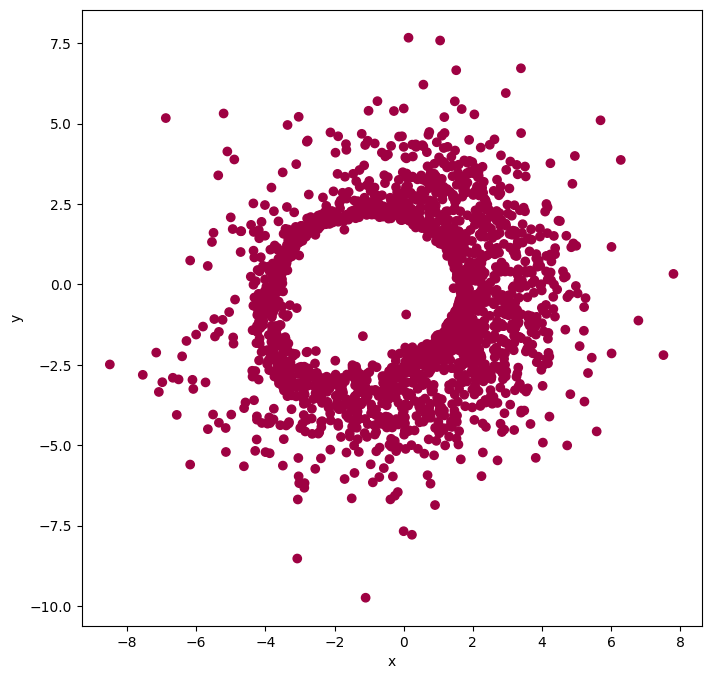

In [16]:
eps = 1e-5 #@param {'type':'number'}
num_samples = 400 #@param {'type':'integer'}

# ode_sampler(score_model,
#                 marginal_prob_std,
#                 diffusion_coeff,
#                 batch_size=64,
#                 atol=error_tolerance,
#                 rtol=error_tolerance,
#                 device='cuda',
#                 z=None,
#                 eps=1e-3)

# Test the prdictor corrector sample function
# sampler = pc_sampler # Euler_Maruyama_sampler, pc_sampler
samples = ode_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, batch_size=num_samples, device=device, eps=eps)

# Convert tensor to numpy array and plot generated samples
samples_np = samples.cpu().detach().numpy()
plot_2d_swiss_roll(samples_np, t=None, title="Generated data samples")